In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import sklearn
from sklearn import cluster
from eofs.standard import Eof
from scipy.cluster.vq import vq

print('libraries loaded')

libraries loaded


In [5]:

# note this takes around a minute to load in 

dataset = Dataset('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/Data/European_MSLP_and_MSLP_anomaly_data.nc')
ERA5_MSLP_anom  = dataset.variables['MSLP_anom'][:]
lons = dataset.variables['lon'][:]
lats = dataset.variables['lat'][:]
dataset.close()

print(np.shape(ERA5_MSLP_anom))
print(lons)

(42, 365, 149, 229)
[-22.   -21.75 -21.5  -21.25 -21.   -20.75 -20.5  -20.25 -20.   -19.75
 -19.5  -19.25 -19.   -18.75 -18.5  -18.25 -18.   -17.75 -17.5  -17.25
 -17.   -16.75 -16.5  -16.25 -16.   -15.75 -15.5  -15.25 -15.   -14.75
 -14.5  -14.25 -14.   -13.75 -13.5  -13.25 -13.   -12.75 -12.5  -12.25
 -12.   -11.75 -11.5  -11.25 -11.   -10.75 -10.5  -10.25 -10.    -9.75
  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75  -7.5   -7.25
  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25  -5.    -4.75
  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75  -2.5   -2.25
  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25   0.     0.25
   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25   2.5    2.75
   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75   5.     5.25
   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25   7.5    7.75
   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75  10.    10.25
  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25 

In [6]:
# reshape the MSLP anom into [time,lat*lon]

# take first 38 years. 
# Take Jan-Mar and concatenate  Dec onto the end of it
DJFM_MSLP = np.concatenate((ERA5_MSLP_anom[0:38,0:90,:,:],ERA5_MSLP_anom[0:38,335:365,:,:]),axis=1)
print(np.shape(DJFM_MSLP))

#reshape into 2d array for creation of EOFS in next step
reshaped_MSLP_anom = np.reshape(DJFM_MSLP,(38*120,len(lats)*len(lons)))


print(np.shape(reshaped_MSLP_anom))

(38, 120, 149, 229)
(4560, 34121)


In [14]:
# create the EOFs
print('set up solver')
solver = Eof(reshaped_MSLP_anom)
print('calculating EOFs')

set up solver
calculating EOFs


In [1]:
print('extracting Principal components')
pcNEOFS = solver.pcs(npcs=14)
print('we have PCs')
print(np.shape(pcNEOFS))

extracting Principal components


NameError: name 'solver' is not defined

(4560,)


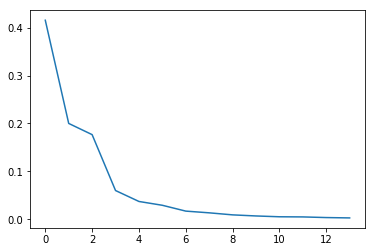

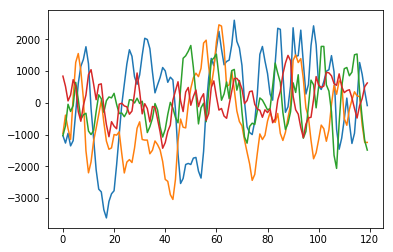

In [25]:
plt.plot(pcNEOFS[0:120,0:4])
plt.show()

In [16]:
# cluster the pcNEOFs

#setup the clustering algorithm
KM4 = cluster.KMeans(n_clusters=30,init='random',n_init=30,max_iter=100)

#calculate the clusters
KM4cls = KM4.fit(pcNEOFS)

cluster_numbers = KM4cls.labels_

In [24]:
np.save('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1',cluster_numbers)
np.save('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1_accompanying_PCs',pcNEOFS)

In [18]:
print(np.shape(cluster_numbers))

(4560,)


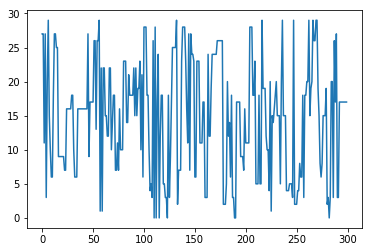

In [36]:
plt.plot(cluster_numbers[0:300])

Text(0, 0.5, 'Number of Occurences')

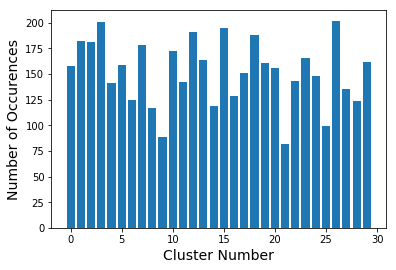

In [23]:
a,b = np.histogram(cluster_numbers,bins=np.linspace(0,30,31))

plt.bar(b[0:len(a)],a)
plt.xlabel('Cluster Number',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)



In [34]:
print(np.max(cluster_numbers))

29


In [35]:
print(np.shape(cluster_numbers))

(4560,)


In [61]:

cluster_mean_centroids = np.zeros([30,len(lats),len(lons)])

for clust_i in range(0,30):
    args_list = np.where(cluster_numbers == clust_i)
    #print(args_list)
    #print(np.shape(args_list))
    
    data_we_need = reshaped_MSLP_anom[args_list[0],:]
    data_we_need_reshaped = np.reshape(data_we_need,(len(args_list[0]),len(lats),len(lons)))
    cluster_centroid = np.mean(data_we_need_reshaped,axis=0)
    cluster_mean_centroids[clust_i,:,:] = cluster_centroid

In [2]:
# Spatial plot of the first day of data
gridded_lons,gridded_lats = np.meshgrid(lons,lats)

# setup colorbar
bounds = np.linspace(-20,20,21)
cmap = plt.cm.bwr
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
# setup plot
fig = plt.figure()
for i in range(0,2):
    print(i)
    ax1 = fig.add_subplot(5,6,i+1,projection=ccrs.PlateCarree())
    cs = plt.pcolor(gridded_lons, gridded_lats, cluster_mean_centroids[i,:,:],cmap =cmap,norm=norm,transform=ccrs.PlateCarree())
    plt.title('Cluster ' + str(i),fontsize=12)
    ax1.coastlines(resolution='50m')
    ax1.add_feature(cartopy.feature.BORDERS)
    

ax2 = fig.add_axes([0.2,0.1,0.6,0.02])    
cb = mpl.colorbar.ColorbarBase(ax2,cmap=cmap,norm=norm,orientation='horizontal',extend='both',ticks=[-20,-10,0,10,20])
cb.set_xlabel('Daily-mean MSLP anomaly (hPa)',fontsize=14)
plt.show()


NameError: name 'np' is not defined